In [1]:
from pyspark.sql import SparkSession
from pylab import rcParams
import matplotlib.pyplot as plt
import seaborn as sns
rcParams['figure.figsize'] = 22, 8
rcParams['font.size'] = 14


In [2]:
spark = SparkSession.builder.\
        master("local[*]").\
        appName("churn-prediction").\
        getOrCreate()

In [51]:
sc = spark.sparkContext

In [3]:
spark

## Read data

In [4]:
file_loc = "/Users/rahul.bhatia/Desktop/end-to-end-pyspark-ml/churn-dataset.csv"
file_type = "csv"

infer_schema = "true"
first_row_is_header = "true"
delimeter = ","

df = spark.read.format(file_type)\
     .option("inferSchema",infer_schema)\
     .option("header",first_row_is_header)\
     .option("sep",delimeter)\
     .option("nanValue",' ')\
     .option("nullValue",' ')\
     .load(file_loc)

In [5]:
# For Better visualization
df.limit(5).toPandas().head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [6]:
df.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Churn: string (nullable = true)



## NULL Checks

In [7]:
from pyspark.sql.functions import isnan,when,count,col
df.select([count(when(isnan(c) | col(c).isNull(),c)).alias(c) for c in df.columns]).show()

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|         0|     0|            0|      0|         0|     0|           0|            0|              0|             0|           0|               0|          0|          0|              0|       0|               0| 

## Create a temp table

In [8]:
temp_table_name = "churn_analysis"
df.createOrReplaceTempView(temp_table_name)

## Some Exploratory Analysis

Checking the class distribution

In [9]:
df.groupBy('Churn').count().show()

+-----+-----+
|Churn|count|
+-----+-----+
|   No| 5174|
|  Yes| 1869|
+-----+-----+



Some descriptive stats for numeric columns.

In [10]:
df.select("tenure","TotalCharges","MonthlyCharges").describe().show()

+-------+------------------+------------------+------------------+
|summary|            tenure|      TotalCharges|    MonthlyCharges|
+-------+------------------+------------------+------------------+
|  count|              7043|              7032|              7043|
|   mean| 32.37114865824223|2283.3004408418697| 64.76169246059922|
| stddev|24.559481023094442| 2266.771361883145|30.090047097678482|
|    min|                 0|              18.8|             18.25|
|    max|                72|            8684.8|            118.75|
+-------+------------------+------------------+------------------+



Looking at churn by gender.

In [11]:
spark.sql("select gender,churn,count(*) from churn_analysis group by gender,churn").show()

+------+-----+--------+
|gender|churn|count(1)|
+------+-----+--------+
|  Male|   No|    2625|
|  Male|  Yes|     930|
|Female|   No|    2549|
|Female|  Yes|     939|
+------+-----+--------+



Above hints that gender might not be relevant feature in this dataset to predict churn.

Looking at churn by gender.

In [12]:
spark.sql("select SeniorCitizen,churn,count(*) from churn_analysis group by SeniorCitizen,churn").show()

+-------------+-----+--------+
|SeniorCitizen|churn|count(1)|
+-------------+-----+--------+
|            1|   No|     666|
|            0|   No|    4508|
|            0|  Yes|    1393|
|            1|  Yes|     476|
+-------------+-----+--------+



Above hints that Senior Citizens are more likely to churn.

### Relation between Churn and Tenure

In [13]:
spark.sql("select cast(tenure as int), churn, count(churn) from churn_analysis group by tenure,churn order by \
           cast(tenure as int)").show()

+------+-----+------------+
|tenure|churn|count(churn)|
+------+-----+------------+
|     0|   No|          11|
|     1|  Yes|         380|
|     1|   No|         233|
|     2|   No|         115|
|     2|  Yes|         123|
|     3|  Yes|          94|
|     3|   No|         106|
|     4|   No|          93|
|     4|  Yes|          83|
|     5|  Yes|          64|
|     5|   No|          69|
|     6|  Yes|          40|
|     6|   No|          70|
|     7|  Yes|          51|
|     7|   No|          80|
|     8|  Yes|          42|
|     8|   No|          81|
|     9|  Yes|          46|
|     9|   No|          73|
|    10|   No|          71|
+------+-----+------------+
only showing top 20 rows



Visualizing above - 

In [14]:
tenure_churn_df = spark.sql("select cast(tenure as int), churn, count(churn) from churn_analysis group by tenure,churn order by \
           cast(tenure as int)").toPandas()

In [15]:
tenure_churn_df.head()

,tenure,churn,count(churn)
0,0,No,11
1,1,No,233
2,1,Yes,380
3,2,No,115
4,2,Yes,123


### Bar Plot

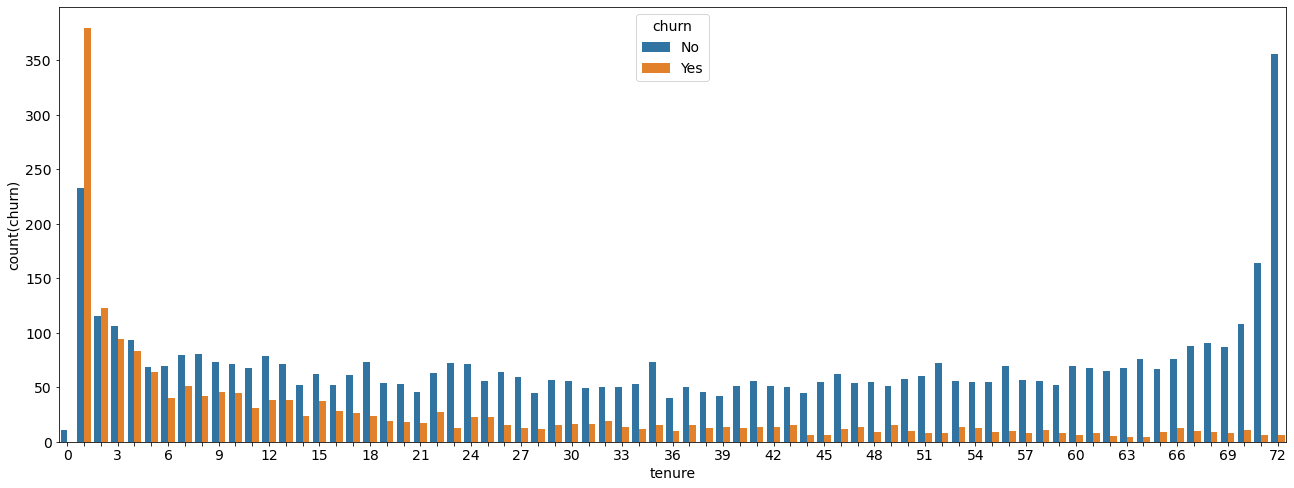

In [16]:
ax = sns.barplot(x = "tenure",y="count(churn)",hue="churn",data=tenure_churn_df)

# Show xticks for only multiple of 3
for ind, label in enumerate(ax.get_xticklabels()):
    if ind % 3 == 0:
        label.set_visible(True)
    else:
        label.set_visible(False)

Customer tend to churn more in the initial tenure, but as tenure increases, churn decreases.

### Checking the internet service used by Senior Citizens

Since senior citizens are churning more, let's analyze what type of internet service do they use.

**crosstab** computes a pair-wise frequency table of the given columns.

In [17]:
df.stat.crosstab("SeniorCitizen","InternetService").show()

+-----------------------------+----+-----------+----+
|SeniorCitizen_InternetService| DSL|Fiber optic|  No|
+-----------------------------+----+-----------+----+
|                            1| 259|        831|  52|
|                            0|2162|       2265|1474|
+-----------------------------+----+-----------+----+



### Checking frequent columns for the categorical variables

In [18]:
df.stat.freqItems(['PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies'],0.6).collect()

[Row(PhoneService_freqItems=['Yes'], MultipleLines_freqItems=['Yes'], InternetService_freqItems=['Fiber optic'], OnlineSecurity_freqItems=['No'], OnlineBackup_freqItems=['Yes'], DeviceProtection_freqItems=['No'], TechSupport_freqItems=['No'], StreamingTV_freqItems=['Yes'], StreamingMovies_freqItems=['No'])]

### Paperless Billing and Payment method impact on Churn

In [19]:
spark.sql('''
    select PaperlessBilling, churn, count(*) from churn_analysis group by PaperlessBilling, churn
''').show()

+----------------+-----+--------+
|PaperlessBilling|churn|count(1)|
+----------------+-----+--------+
|             Yes|  Yes|    1400|
|              No|   No|    2403|
|             Yes|   No|    2771|
|              No|  Yes|     469|
+----------------+-----+--------+



Above shows that people who opt for paper-less billing are more liekly to churn. This is just a correlation not causation.

In [20]:
spark.sql('''
    select PaymentMethod, churn, count(*) from churn_analysis group by PaymentMethod, churn
''').show()

+--------------------+-----+--------+
|       PaymentMethod|churn|count(1)|
+--------------------+-----+--------+
|Credit card (auto...|   No|    1290|
|Bank transfer (au...|   No|    1286|
|        Mailed check|  Yes|     308|
|Credit card (auto...|  Yes|     232|
|    Electronic check|   No|    1294|
|    Electronic check|  Yes|    1071|
|Bank transfer (au...|  Yes|     258|
|        Mailed check|   No|    1304|
+--------------------+-----+--------+



## Data Preprocessing, Machine Learning and Evaluation

### Random split into train-test

In [21]:
churn_df = df
(train_data, test_data) = churn_df.randomSplit([0.7, 0.3], 24)

print("Records for training: " + str(train_data.count()))
print("Records for evaluation: " + str(test_data.count()))

Records for training: 4916
Records for evaluation: 2127


### Building stages for pipelines

In [22]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler

catColumns = ["gender", "SeniorCitizen", "Partner", "Dependents", "PhoneService", "MultipleLines", "InternetService", "OnlineSecurity","OnlineBackup","DeviceProtection","TechSupport","StreamingTV","StreamingMovies","Contract","PaperlessBilling","PaymentMethod"]

In [23]:
stages= []

for catCol in catColumns:
    # StringIndexer is very similar to LabelEncoder from sklearn
    stringIndexer = StringIndexer(inputCol=catCol, outputCol=catCol + "Index")
    
    oneHotEncoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[catCol + "catVec"])

    stages += [stringIndexer, oneHotEncoder]

In [24]:
# For each categorical variable, we have a string indexer and a one-hot-encoder.
stages

[StringIndexer_31b0edfe0ace,
 OneHotEncoderEstimator_75db1e050334,
 StringIndexer_44614879139b,
 OneHotEncoderEstimator_6704b115cfaf,
 StringIndexer_3f21df3ec6e9,
 OneHotEncoderEstimator_9ad424a9553a,
 StringIndexer_5259d01da90c,
 OneHotEncoderEstimator_e939df053771,
 StringIndexer_7d1b2752b67d,
 OneHotEncoderEstimator_ba7b6e9a5725,
 StringIndexer_e3125d8f7a71,
 OneHotEncoderEstimator_f83e99fe6f44,
 StringIndexer_d3364c844645,
 OneHotEncoderEstimator_417cab04fd2b,
 StringIndexer_1d04064f27a7,
 OneHotEncoderEstimator_025d598fee25,
 StringIndexer_a729091c8e2c,
 OneHotEncoderEstimator_9b3df4576c1c,
 StringIndexer_f6473407a5bb,
 OneHotEncoderEstimator_44475275b48e,
 StringIndexer_2ef210b03583,
 OneHotEncoderEstimator_c4256988dd2c,
 StringIndexer_54ba80aee14a,
 OneHotEncoderEstimator_640e5c042a6f,
 StringIndexer_cf0c49a2e1dc,
 OneHotEncoderEstimator_e4e1c0d81ac9,
 StringIndexer_4a3d2c1421db,
 OneHotEncoderEstimator_e22072848afa,
 StringIndexer_f95a64ef657b,
 OneHotEncoderEstimator_d6d7252ff

### Handling numeric values(imputation)

In [25]:
## The column TotalCharges has some missing values, we needs to be imputed.

# Mean imputation happens by default
from pyspark.ml.feature import Imputer
imputer = Imputer(inputCols=["TotalCharges"], outputCols=["Out_TotalCharges"])
stages += [imputer]

In [26]:
# Convert Yes/No in the dependent variable to 0/1
label_Idx = StringIndexer(inputCol="Churn", outputCol="label")
stages += [label_Idx]

### Some Feature Engineering and selection

In [27]:
# We can check the correlation to decide which one we can keep amongst TotalCharges and MonthlyCharges, here we can keep both
df.stat.corr('TotalCharges', 'MonthlyCharges')

0.6511738315787813

In [28]:
spark.sql('''
select cast(tenure as int), churn, count(*) as churned from churn_analysis where churn='Yes' \
group by tenure, churn order by cast(tenure as int)
''').show()

+------+-----+-------+
|tenure|churn|churned|
+------+-----+-------+
|     1|  Yes|    380|
|     2|  Yes|    123|
|     3|  Yes|     94|
|     4|  Yes|     83|
|     5|  Yes|     64|
|     6|  Yes|     40|
|     7|  Yes|     51|
|     8|  Yes|     42|
|     9|  Yes|     46|
|    10|  Yes|     45|
|    11|  Yes|     31|
|    12|  Yes|     38|
|    13|  Yes|     38|
|    14|  Yes|     24|
|    15|  Yes|     37|
|    16|  Yes|     28|
|    17|  Yes|     26|
|    18|  Yes|     24|
|    19|  Yes|     19|
|    20|  Yes|     18|
+------+-----+-------+
only showing top 20 rows



We can see that as tenure increases, churn decreases, we can bin the tenure column.

### Binning tenure

In [29]:
# QuantileDiscretizer can be used to bin
from pyspark.ml.feature import QuantileDiscretizer
tenure_bin = QuantileDiscretizer(numBuckets=3, inputCol="tenure", outputCol="tenure_bin")
stages += [tenure_bin]

## Create a vectorAssembler for final ML Model

In [30]:
numericCols = ["tenure_bin", "Out_TotalCharges","MonthlyCharges"]
assembleInputs = assemblerInputs = [c + "catVec" for c in catColumns] + numericCols
assembler = VectorAssembler(inputCols=assembleInputs, outputCol="features")
stages += [assembler]

## Create the final pipeline

In [32]:
pipeline = Pipeline().setStages(stages)
pipelineModel = pipeline.fit(train_data)

In [33]:
# Finally transform using the above pipeline
trainprepDF = pipelineModel.transform(train_data)
testprepDF = pipelineModel.transform(test_data)

In [35]:
trainprepDF.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Churn: string (nullable = true)
 |-- genderIndex: double (nullable = false)
 |-- gendercatVec: vector (nullable = 

In [36]:
trainprepDF.select("tenure_bin").show()

+----------+
|tenure_bin|
+----------+
|       0.0|
|       0.0|
|       2.0|
|       0.0|
|       2.0|
|       2.0|
|       0.0|
|       2.0|
|       0.0|
|       1.0|
|       2.0|
|       0.0|
|       1.0|
|       0.0|
|       0.0|
|       2.0|
|       1.0|
|       2.0|
|       2.0|
|       1.0|
+----------+
only showing top 20 rows



## Fitting a model 

In [37]:
from pyspark.ml.classification import LogisticRegression

# Create initial LogisticRegression model
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)

# Train model with Training Data
lrModel = lr.fit(trainprepDF)

In [38]:
print("Coefficients: " + str(lrModel.coefficients))
print("Intercept: " + str(lrModel.intercept))

Coefficients: [-0.022125908958674067,-0.295966602853141,-0.04540190713043998,0.11422451989175594,-0.5443650552564775,-0.25787179594555176,0.06759355518729251,0.558940086914602,-0.3986256243196881,0.3000315276725239,-0.13495490629289175,0.1906494657387726,0.0034263879839864985,0.1139377637255167,0.0864700306602351,0.26398039586831734,-0.08866299958063091,0.005764718914013356,0.1946886963208213,-0.012545144725579329,0.21249251749087097,0.7226916232199266,-0.7941298473778351,0.30458357823925264,0.18868980558464654,-0.11391177062150766,-0.27808713414588604,-0.6330144913097795,-0.00011781853833584495,0.004850253631019678]
Intercept: -1.1241531294140892


## Evaluator

In [41]:
summary = lrModel.summary

In [42]:
# Metrics on the training dataset

accuracy = summary.accuracy
falsePositiveRate = summary.weightedFalsePositiveRate
truePositiveRate = summary.weightedTruePositiveRate
fMeasure = summary.weightedFMeasure()
precision = summary.weightedPrecision
recall = summary.weightedRecall
print("Accuracy: %s\nFPR: %s\nTPR: %s\nF-measure: %s\nPrecision: %s\nRecall: %s\nAreaUnderROC: %s"
      % (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall, summary.areaUnderROC))

Accuracy: 0.7971928397070789
FPR: 0.3543249783512605
TPR: 0.7971928397070789
F-measure: 0.7916719573031158
Precision: 0.7893734580163737
Recall: 0.7971928397070789
AreaUnderROC: 0.8462856449884067


In [62]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
predictions = lrModel.transform(testprepDF)
predictions.toPandas().head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,PaperlessBillingcatVec,PaymentMethodIndex,PaymentMethodcatVec,Out_TotalCharges,label,tenure_bin,features,rawPrediction,probability,prediction
0,0002-ORFBO,Female,0,Yes,Yes,9,Yes,No,DSL,No,...,(1.0),1.0,"(0.0, 1.0, 0.0)",593.30,0.0,0.0,"(1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, ...","[1.6932851783330047, -1.6932851783330047]","[0.8446557043895172, 0.15534429561048285]",0.0
1,0003-MKNFE,Male,0,No,No,9,Yes,Yes,DSL,No,...,(0.0),1.0,"(0.0, 1.0, 0.0)",542.40,0.0,0.0,"(0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...","[0.30443258458163713, -0.30443258458163713]","[0.5755257397472802, 0.42447426025271984]",0.0
2,0011-IGKFF,Male,1,Yes,No,13,Yes,No,Fiber optic,No,...,(1.0),0.0,"(1.0, 0.0, 0.0)",1237.85,1.0,0.0,"(0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, ...","[-1.3533123673917233, 1.3533123673917233]","[0.20532936784584072, 0.7946706321541593]",1.0
3,0013-MHZWF,Female,0,No,Yes,9,Yes,No,DSL,No,...,(1.0),2.0,"(0.0, 0.0, 1.0)",571.45,0.0,0.0,"(1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, ...","[0.7469047869361469, -0.7469047869361469]","[0.6785038940384932, 0.3214961059615068]",0.0
4,0013-SMEOE,Female,1,Yes,No,71,Yes,No,Fiber optic,Yes,...,(1.0),3.0,"(0.0, 0.0, 0.0)",7904.25,0.0,2.0,"(1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, ...","[3.1566611662624284, -3.1566611662624284]","[0.9591703894511711, 0.040829610548828846]",0.0


In [63]:
evaluatorLR = BinaryClassificationEvaluator(rawPredictionCol="prediction")
area_under_curve = evaluatorLR.evaluate(predictions)

#default evaluation is areaUnderROC
print("areaUnderROC = %g" % area_under_curve)


areaUnderROC = 0.723089


In [53]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics

results = predictions.select(['prediction', 'label'])
 
## prepare score-label set
results_collect = results.collect()
results_list = [(float(i[0]), float(i[1])) for i in results_collect]
predictionAndLabels = sc.parallelize(results_list)
 
metrics = BinaryClassificationMetrics(predictionAndLabels)

# Area under precision-recall curve
print("Area under PR = %s" % metrics.areaUnderPR)

# Area under ROC curve
print("Area under ROC = %s" % metrics.areaUnderROC)


Area under PR = 0.5264394725677182
Area under ROC = 0.7230887671429083


## Cross-Validation to improve above model

In [54]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(lr.maxIter, [5, 10, 20])
             .build())

In [55]:
cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluatorLR, numFolds=5)

# Run cross validations
cvModel = cv.fit(trainprepDF)

In [56]:
predictions = cvModel.bestModel.transform(testprepDF)

In [65]:
predictions.toPandas().head(1)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,PaperlessBillingcatVec,PaymentMethodIndex,PaymentMethodcatVec,Out_TotalCharges,label,tenure_bin,features,rawPrediction,probability,prediction
0,0002-ORFBO,Female,0,Yes,Yes,9,Yes,No,DSL,No,...,(1.0),1.0,"(0.0, 1.0, 0.0)",593.3,0.0,0.0,"(1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, ...","[1.6932851783330047, -1.6932851783330047]","[0.8446557043895172, 0.15534429561048285]",0.0


In [67]:
evaluatorLR.evaluate(predictions)

0.7230887671429083